In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from keras.datasets import mnist

from optimizers import SGD, Nesterov, Adam, LBFGS

### Load MNIST

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[(y_train == 1) | (y_train == 7)].reshape((-1, np.prod(X_train.shape[1:]))) / 255.
y_train = 2 * (y_train[(y_train == 1) | (y_train == 7)] == 1) - 1
X_test = X_test[(y_test == 1) | (y_test == 7)].reshape((-1, np.prod(X_test.shape[1:]))) / 255.
y_test = 2 * (y_test[(y_test == 1) | (y_test == 7)] == 1) - 1

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(13007, 784) (13007,)
(2163, 784) (2163,)


#### PCA Helper

In [3]:
def PCA_transform(d):
    pca = PCA(n_components=d)
    X_train_d = pca.fit_transform(X_train)
    X_test_d = pca.transform(X_test)
    return X_train_d, X_test_d

### Posing Optimization Problem

In [4]:
# constructs 2d array of data feature coefficients in quadratic test function
# equivalent to a linear system with parameter vector w, ie.
# y * (x.T @ W @ x + v.T @ x + b) == get_quadratic(x, y) @ w
def get_quadratic(X_data, y_data):
    quad_term = (X_data[:, :, np.newaxis] * X_data[:, np.newaxis, :]).reshape((len(X_data), -1))
    quadratic = y_data[:, np.newaxis] * np.hstack((quad_term, X_data, np.ones((len(X_data), 1))))
    return quadratic.astype(np.float128)

# loss function over entire training set
def loss_function(w, train_data, lam=1e-3):
    return np.sum(np.log(1 + np.exp(-train_data @ w))) / len(train_data) + lam / 2 * np.sum(w ** 2)

# gradient function allows for different batches
def loss_gradient(w, data_batch, lam=1e-3):
    exp_quad = np.exp(-data_batch @ w)
    coef = exp_quad / (1 + exp_quad)
    return np.sum(-data_batch * coef[:, np.newaxis], axis=0) / len(data_batch) + lam * w

### Experiments

#### Functions

In [5]:
def eval_test_func(w, train_data, test_data, silent=True):
    eval_train = (train_data @ w > 0).astype(int)
    eval_test = (test_data @ w > 0).astype(int)
    correct_train = sum(eval_train)
    correct_test = sum(eval_test)
    acc_train = correct_train / len(eval_train)
    acc_test = correct_test / len(eval_test)
    if not silent:
        print(f'train correct: {correct_train}, train accuracy: {acc_train}')
        print(f'test correct: {correct_test}, test accuracy: {acc_test}')
    return acc_train, acc_test

In [6]:
def compare_batch_size(batch_sizes, dir):
    X_train_20, X_test_20 = PCA_transform(20)
    quad_train = get_quadratic(X_train_20, y_train)
    quad_test = get_quadratic(X_test_20, y_test)

    results = pd.DataFrame(columns=[
        "batch_size",
        "SGD",
        "Nesterov",
        "Adam",
        "LBFGS"
    ])

    loss_fig = plt.figure(constrained_layout=True, figsize=(4*len(batch_sizes), 20))
    loss_fig.suptitle("L(w) varying batch sizes", fontsize=20)
    loss_fig.supylabel("Batch size")
    loss_subfigs = loss_fig.subfigures(len(batch_sizes), 1)

    norm_fig = plt.figure(constrained_layout=True, figsize=(4*len(batch_sizes), 20))
    norm_fig.suptitle(r"$\|\nabla L(w)\|$ varying batch sizes", fontsize=20)
    norm_fig.supylabel("Batch size")
    norm_subfigs = norm_fig.subfigures(len(batch_sizes), 1)

    for i, batch_size in enumerate(batch_sizes):
        row = { "batch_size": batch_size }
        
        loss_axs = loss_subfigs[i].subplots(1, 4)
        norm_axs = norm_subfigs[i].subplots(1, 4)
        loss_subfigs[i].supylabel(batch_size)
        norm_subfigs[i].supylabel(batch_size)

        params = {
            "data": quad_train,
            "batch_size": batch_size,
            "step_size": 0.01,
            "epochs": 10,
            "loss": loss_function,
            "grad": loss_gradient,
        }

        for j, optclass in enumerate([SGD, Nesterov, Adam, LBFGS]):
            params["step_size"] = None if optclass is LBFGS else 0.01
            opt = optclass(**params)
            w_opt = opt.minimize()
            acc_train, acc_test = eval_test_func(w_opt, quad_train, quad_test)

            row[str(opt)] = acc_test

            loss_hist, grad_norms = opt.get_histories()
            loss_axs[j].set_title('{} / Final L(w) = {:.4f}'.format(str(opt), loss_hist[-1]))
            loss_axs[j].set_xlabel('Epoch')
            loss_axs[j].set_ylabel('L(w)')
            loss_axs[j].plot(loss_hist)
            norm_axs[j].set_title(r'{} / Final $\|\nabla L(w)\|$ = {:.4f}'.format(str(opt), grad_norms[-1]))
            norm_axs[j].set_xlabel('k')
            norm_axs[j].set_ylabel(r'$\|\nabla L(w)\|$')
            norm_axs[j].plot(grad_norms)

        results = pd.concat([results, pd.Series(row).to_frame().T], ignore_index=True)
    
    results.to_csv(dir + '/batch_sizes_acc_test.csv')
    loss_fig.savefig(dir + '/batch_sizes_loss.png')
    norm_fig.savefig(dir + '/batch_sizes_norms.png')

In [7]:
def sgd_stepsize_strategies(strategies, dir):
    X_train_20, X_test_20 = PCA_transform(20)
    quad_train = get_quadratic(X_train_20, y_train)
    quad_test = get_quadratic(X_test_20, y_test)

    results = pd.DataFrame(columns=[
        "strategy",
        "SGD"
    ])

    loss_fig, loss_axs = plt.subplots(1, len(strategies), figsize=(4*len(strategies), 4))
    loss_fig.suptitle("L(w) varying step size strategy for SGD", fontsize=20)
    loss_fig.tight_layout()

    norm_fig, norm_axs = plt.subplots(1, len(strategies), figsize=(4*len(strategies), 4))
    norm_fig.suptitle(r"$\|\nabla L(w)\|$ varying step size strategy for SGD", fontsize=20)
    norm_fig.tight_layout()

    for i, strategy in enumerate(strategies):
        row = { "strategy": i }

        params = {
            "data": quad_train,
            "batch_size": 100,
            "step_size": strategy,
            "epochs": 10,
            "loss": loss_function,
            "grad": loss_gradient,
        }

        sgd = SGD(**params)
        w_sgd = sgd.minimize()
        acc_train, acc_test = eval_test_func(w_sgd, quad_train, quad_test)

        row["SGD"] = acc_test
        results = pd.concat([results, pd.Series(row).to_frame().T], ignore_index=True)

        loss_hist, grad_norms = sgd.get_histories()
        loss_axs[i].set_title('Strategy {} / Final L(w) = {:.4f}'.format(i, loss_hist[-1]))
        loss_axs[i].set_xlabel('Epoch')
        loss_axs[i].set_ylabel('L(w)')
        loss_axs[i].plot(loss_hist)
        norm_axs[i].set_title(r'Strategy {} / Final $\|\nabla L(w)\|$ = {:.4f}'.format(i, grad_norms[-1]))
        norm_axs[i].set_xlabel('k')
        norm_axs[i].set_ylabel(r'$\|\nabla L(w)\|$')
        norm_axs[i].plot(grad_norms)

    results.to_csv(dir + '/sgd_strategies_acc_test.csv')
    loss_fig.savefig(dir + '/sgd_strategies_loss.png')
    norm_fig.savefig(dir + '/sgd_strategies_norms.png')

In [8]:
def lbfgs_stepsize(stepsizes, dir):
    X_train_20, X_test_20 = PCA_transform(20)
    quad_train = get_quadratic(X_train_20, y_train)
    quad_test = get_quadratic(X_test_20, y_test)

    results = pd.DataFrame(columns=[
        "Step size",
        "LBFGS"
    ])

    loss_fig, loss_axs = plt.subplots(1, len(stepsizes), figsize=(4*len(stepsizes), 4))
    loss_fig.suptitle("L(w) varying step size for LBFGS", fontsize=20)
    loss_fig.tight_layout()

    norm_fig, norm_axs = plt.subplots(1, len(stepsizes), figsize=(4*len(stepsizes), 4))
    norm_fig.suptitle(r"$\|\nabla L(w)\|$ varying step size strategy for LBFGS", fontsize=20)
    norm_fig.tight_layout()

    for i, step_size in enumerate(stepsizes):
        row = { "Step size": step_size }

        params = {
            "data": quad_train,
            "batch_size": 1000,
            "step_size": step_size,
            "epochs": 10,
            "loss": loss_function,
            "grad": loss_gradient,
        }

        lbfgs = LBFGS(**params)
        w_lbfgs = lbfgs.minimize()
        acc_train, acc_test = eval_test_func(w_lbfgs, quad_train, quad_test)

        row["LBFGS"] = acc_test
        results = pd.concat([results, pd.Series(row).to_frame().T], ignore_index=True)

        loss_hist, grad_norms = lbfgs.get_histories()
        loss_axs[i].set_title('Step size {} / Final L(w) = {:.4f}'.format(step_size, loss_hist[-1]))
        loss_axs[i].set_xlabel('Epoch')
        loss_axs[i].set_ylabel('L(w)')
        loss_axs[i].plot(loss_hist)
        norm_axs[i].set_title(r'Step size {} / Final $\|\nabla L(w)\|$ = {:.4f}'.format(step_size, grad_norms[-1]))
        norm_axs[i].set_xlabel('k')
        norm_axs[i].set_ylabel(r'$\|\nabla L(w)\|$')
        norm_axs[i].plot(grad_norms)

    results.to_csv(dir + '/lbfgs_stepsize_acc_test.csv')
    loss_fig.savefig(dir + '/lbfgs_stepsize_loss.png')
    norm_fig.savefig(dir + '/lbfgs_stepsize_norms.png')

In [9]:
def lbfgs_pairs_update(ms, frequencies, dir):
    X_train_20, X_test_20 = PCA_transform(20)
    quad_train = get_quadratic(X_train_20, y_train)
    quad_test = get_quadratic(X_test_20, y_test)

    results = pd.DataFrame(columns=[
        "m",
        "frequency",
        "LBFGS"
    ])

    loss_fig = plt.figure(constrained_layout=True, figsize=(4*len(ms), 4*len(frequencies)))
    loss_fig.suptitle("L(w) varying LBFGS m and update frequency", fontsize=20)
    loss_fig.supylabel("m")
    loss_subfigs = loss_fig.subfigures(len(ms), 1)

    norm_fig = plt.figure(constrained_layout=True, figsize=(4*len(ms), 4*len(frequencies)))
    norm_fig.suptitle(r"$\|\nabla L(w)\|$ varying LBFGS m and update frequency", fontsize=20)
    norm_fig.supylabel("m")
    norm_subfigs = norm_fig.subfigures(len(ms), 1)

    for i, m in enumerate(ms):
        loss_axs = loss_subfigs[i].subplots(1, len(frequencies))
        norm_axs = norm_subfigs[i].subplots(1, len(frequencies))
        loss_subfigs[i].supylabel(m)
        norm_subfigs[i].supylabel(m)

        for j, update_freq in enumerate(frequencies):
            row = { "m": m, "frequency": update_freq }

            params = {
                "data": quad_train,
                "batch_size": 1000,
                "step_size": None,
                "epochs": 10,
                "loss": loss_function,
                "grad": loss_gradient,
                "m": m,
                "update_freq": update_freq,
            }

            lbfgs = LBFGS(**params)
            w_lbfgs = lbfgs.minimize()
            acc_train, acc_test = eval_test_func(w_lbfgs, quad_train, quad_test)

            row["LBFGS"] = acc_test
            results = pd.concat([results, pd.Series(row).to_frame().T], ignore_index=True)

            loss_hist, grad_norms = lbfgs.get_histories()
            loss_axs[j].set_title('Frequency {} / Final L(w) = {:.4f}'.format(update_freq, loss_hist[-1]))
            loss_axs[j].set_xlabel('Epoch')
            loss_axs[j].set_ylabel('L(w)')
            loss_axs[j].plot(loss_hist)
            norm_axs[j].set_title(r'Frequency {} / Final $\|\nabla L(w)\|$ = {:.4f}'.format(update_freq, grad_norms[-1]))
            norm_axs[j].set_xlabel('k')
            norm_axs[j].set_ylabel(r'$\|\nabla L(w)\|$')
            norm_axs[j].plot(grad_norms)

    results.to_csv(dir + '/lbfgs_pairs_acc_test.csv')
    loss_fig.savefig(dir + '/lbfgs_pairs_loss.png')
    norm_fig.savefig(dir + '/lbfgs_pairs_norms.png')

In [10]:
def vary_pca(ds, dir):
    results = pd.DataFrame(columns=[
        "d",
        "Adam"
    ])

    loss_fig, loss_axs = plt.subplots(2, len(ds)//2, figsize=(4*len(ds)//2, 8))
    loss_fig.suptitle("L(w) varying PCA ndim", fontsize=20)
    # loss_fig.tight_layout()

    norm_fig, norm_axs = plt.subplots(2, len(ds)//2, figsize=(4*len(ds)//2, 8))
    norm_fig.suptitle(r"$\|\nabla L(w)\|$ varying PCA ndim", fontsize=20)
    # norm_fig.tight_layout()
    
    for i, d in enumerate(ds):
        X_train_d, X_test_d = PCA_transform(d)
        quad_train = get_quadratic(X_train_d, y_train)
        quad_test = get_quadratic(X_test_d, y_test)

        row = { "d": d }

        params = {
            "data": quad_train,
            "batch_size": 100,
            "step_size": 0.01,
            "epochs": 10,
            "loss": loss_function,
            "grad": loss_gradient,
        }

        opt = Adam(**params)
        w_opt = opt.minimize()
        acc_train, acc_test = eval_test_func(w_opt, quad_train, quad_test)

        row["Adam"] = acc_test

        loss_hist, grad_norms = opt.get_histories()
        loss_axs[i//(len(ds)//2)][i%(len(ds)//2)].set_title('ndim={} / Final L(w) = {:.4f}'.format(d, loss_hist[-1]))
        loss_axs[i//(len(ds)//2)][i%(len(ds)//2)].set_xlabel('Epoch')
        loss_axs[i//(len(ds)//2)][i%(len(ds)//2)].set_ylabel('L(w)')
        loss_axs[i//(len(ds)//2)][i%(len(ds)//2)].plot(loss_hist)
        norm_axs[i//(len(ds)//2)][i%(len(ds)//2)].set_title(r'ndim={} / Final $\|\nabla L(w)\|$ = {:.4f}'.format(d, grad_norms[-1]))
        norm_axs[i//(len(ds)//2)][i%(len(ds)//2)].set_xlabel('k')
        norm_axs[i//(len(ds)//2)][i%(len(ds)//2)].set_ylabel(r'$\|\nabla L(w)\|$')
        norm_axs[i//(len(ds)//2)][i%(len(ds)//2)].plot(grad_norms)

        results = pd.concat([results, pd.Series(row).to_frame().T], ignore_index=True)

    results.to_csv(dir + '/pca_acc_test.csv')
    loss_fig.savefig(dir + '/pca_loss.png')
    norm_fig.savefig(dir + '/pca_norms.png')

In [11]:
def pca_3_plot(dir):
    X_train_3, X_test_3 = PCA_transform(3)
    train_1 = X_train_3[y_train == 1]
    train_7 = X_train_3[y_train == -1]
    test_1 = X_test_3[y_test == 1]
    test_7 = X_test_3[y_test == -1]
    quad_train = get_quadratic(X_train_3, y_train)
    quad_test = get_quadratic(X_test_3, y_test)

    params = {
        "data": quad_train,
        "batch_size": 100,
        "step_size": 0.01,
        "epochs": 10,
        "loss": loss_function,
        "grad": loss_gradient,
    }

    opt = Adam(**params)
    w_opt = opt.minimize()
    acc_train, acc_test = eval_test_func(w_opt, quad_train, quad_test, silent=False)

    xx, yy = np.meshgrid(range(int(np.floor(min(train_1[:,0]))), int(np.ceil(max(train_1[:,0])))),
                    range(int(np.floor(min(train_1[:,1]))), int(np.ceil(max(train_1[:,1])))))
    a = w_opt[8]
    b = (w_opt[2] + w_opt[6]) * xx + (w_opt[5] + w_opt[7]) * yy + w_opt[11]
    c = w_opt[0] * (xx ** 2) + (w_opt[1] + w_opt[3]) * (xx * yy) + w_opt[4] * (yy ** 2) \
        + w_opt[9] * xx + w_opt[10] * yy + w_opt[12]
    disc = np.sqrt((b ** 2) - 4 * a * c)
    z1 = (-b - disc) / (2 * a)
    z2 = (-b + disc) / (2 * a)

    ax = plt.axes(projection='3d')
    ax.set_title('3D Visualization Train')
    ax.scatter(train_1[:,0], train_1[:,1], train_1[:,2], c='r')
    ax.scatter(train_7[:,0], train_7[:,1], train_7[:,2], c='b')
    ax.plot_surface(xx, yy, z1, alpha=0.3, color='k')
    ax.plot_surface(xx, yy, z2, alpha=0.3, color='k')
    ax.azim = -75
    ax.elev = 10
    plt.savefig(dir + '/pca_3_train.png')
    plt.show()
    
    ax = plt.axes(projection='3d')
    ax.set_title('3D Visualization Test')
    ax.scatter(test_1[:,0], test_1[:,1], test_1[:,2], c='#FF775A')
    ax.scatter(test_7[:,0], test_7[:,1], test_7[:,2], c='#5AE1FF')
    ax.plot_surface(xx, yy, z1, alpha=0.3, color='k')
    ax.plot_surface(xx, yy, z2, alpha=0.3, color='k')
    ax.azim = -75
    ax.elev = 10
    plt.savefig(dir + '/pca_3_test.png')
    plt.show()

#### Experiment Runs

L-BFGS:  50%|█████     | 5/10 [02:00<02:22, 28.48s/it]/var/folders/jk/dnxlzcwx6jb9l9bdnwvqyrlc0000gn/T/ipykernel_79681/397193124.py:11: RuntimeWarning: overflow encountered in exp
  return np.sum(np.log(1 + np.exp(-train_data @ w))) / len(train_data) + lam / 2 * np.sum(w ** 2)
/var/folders/jk/dnxlzcwx6jb9l9bdnwvqyrlc0000gn/T/ipykernel_79681/397193124.py:15: RuntimeWarning: overflow encountered in exp
  exp_quad = np.exp(-data_batch @ w)
/var/folders/jk/dnxlzcwx6jb9l9bdnwvqyrlc0000gn/T/ipykernel_79681/397193124.py:16: RuntimeWarning: invalid value encountered in divide
  coef = exp_quad / (1 + exp_quad)
L-BFGS: 100%|██████████| 10/10 [02:53<00:00, 17.32s/it]


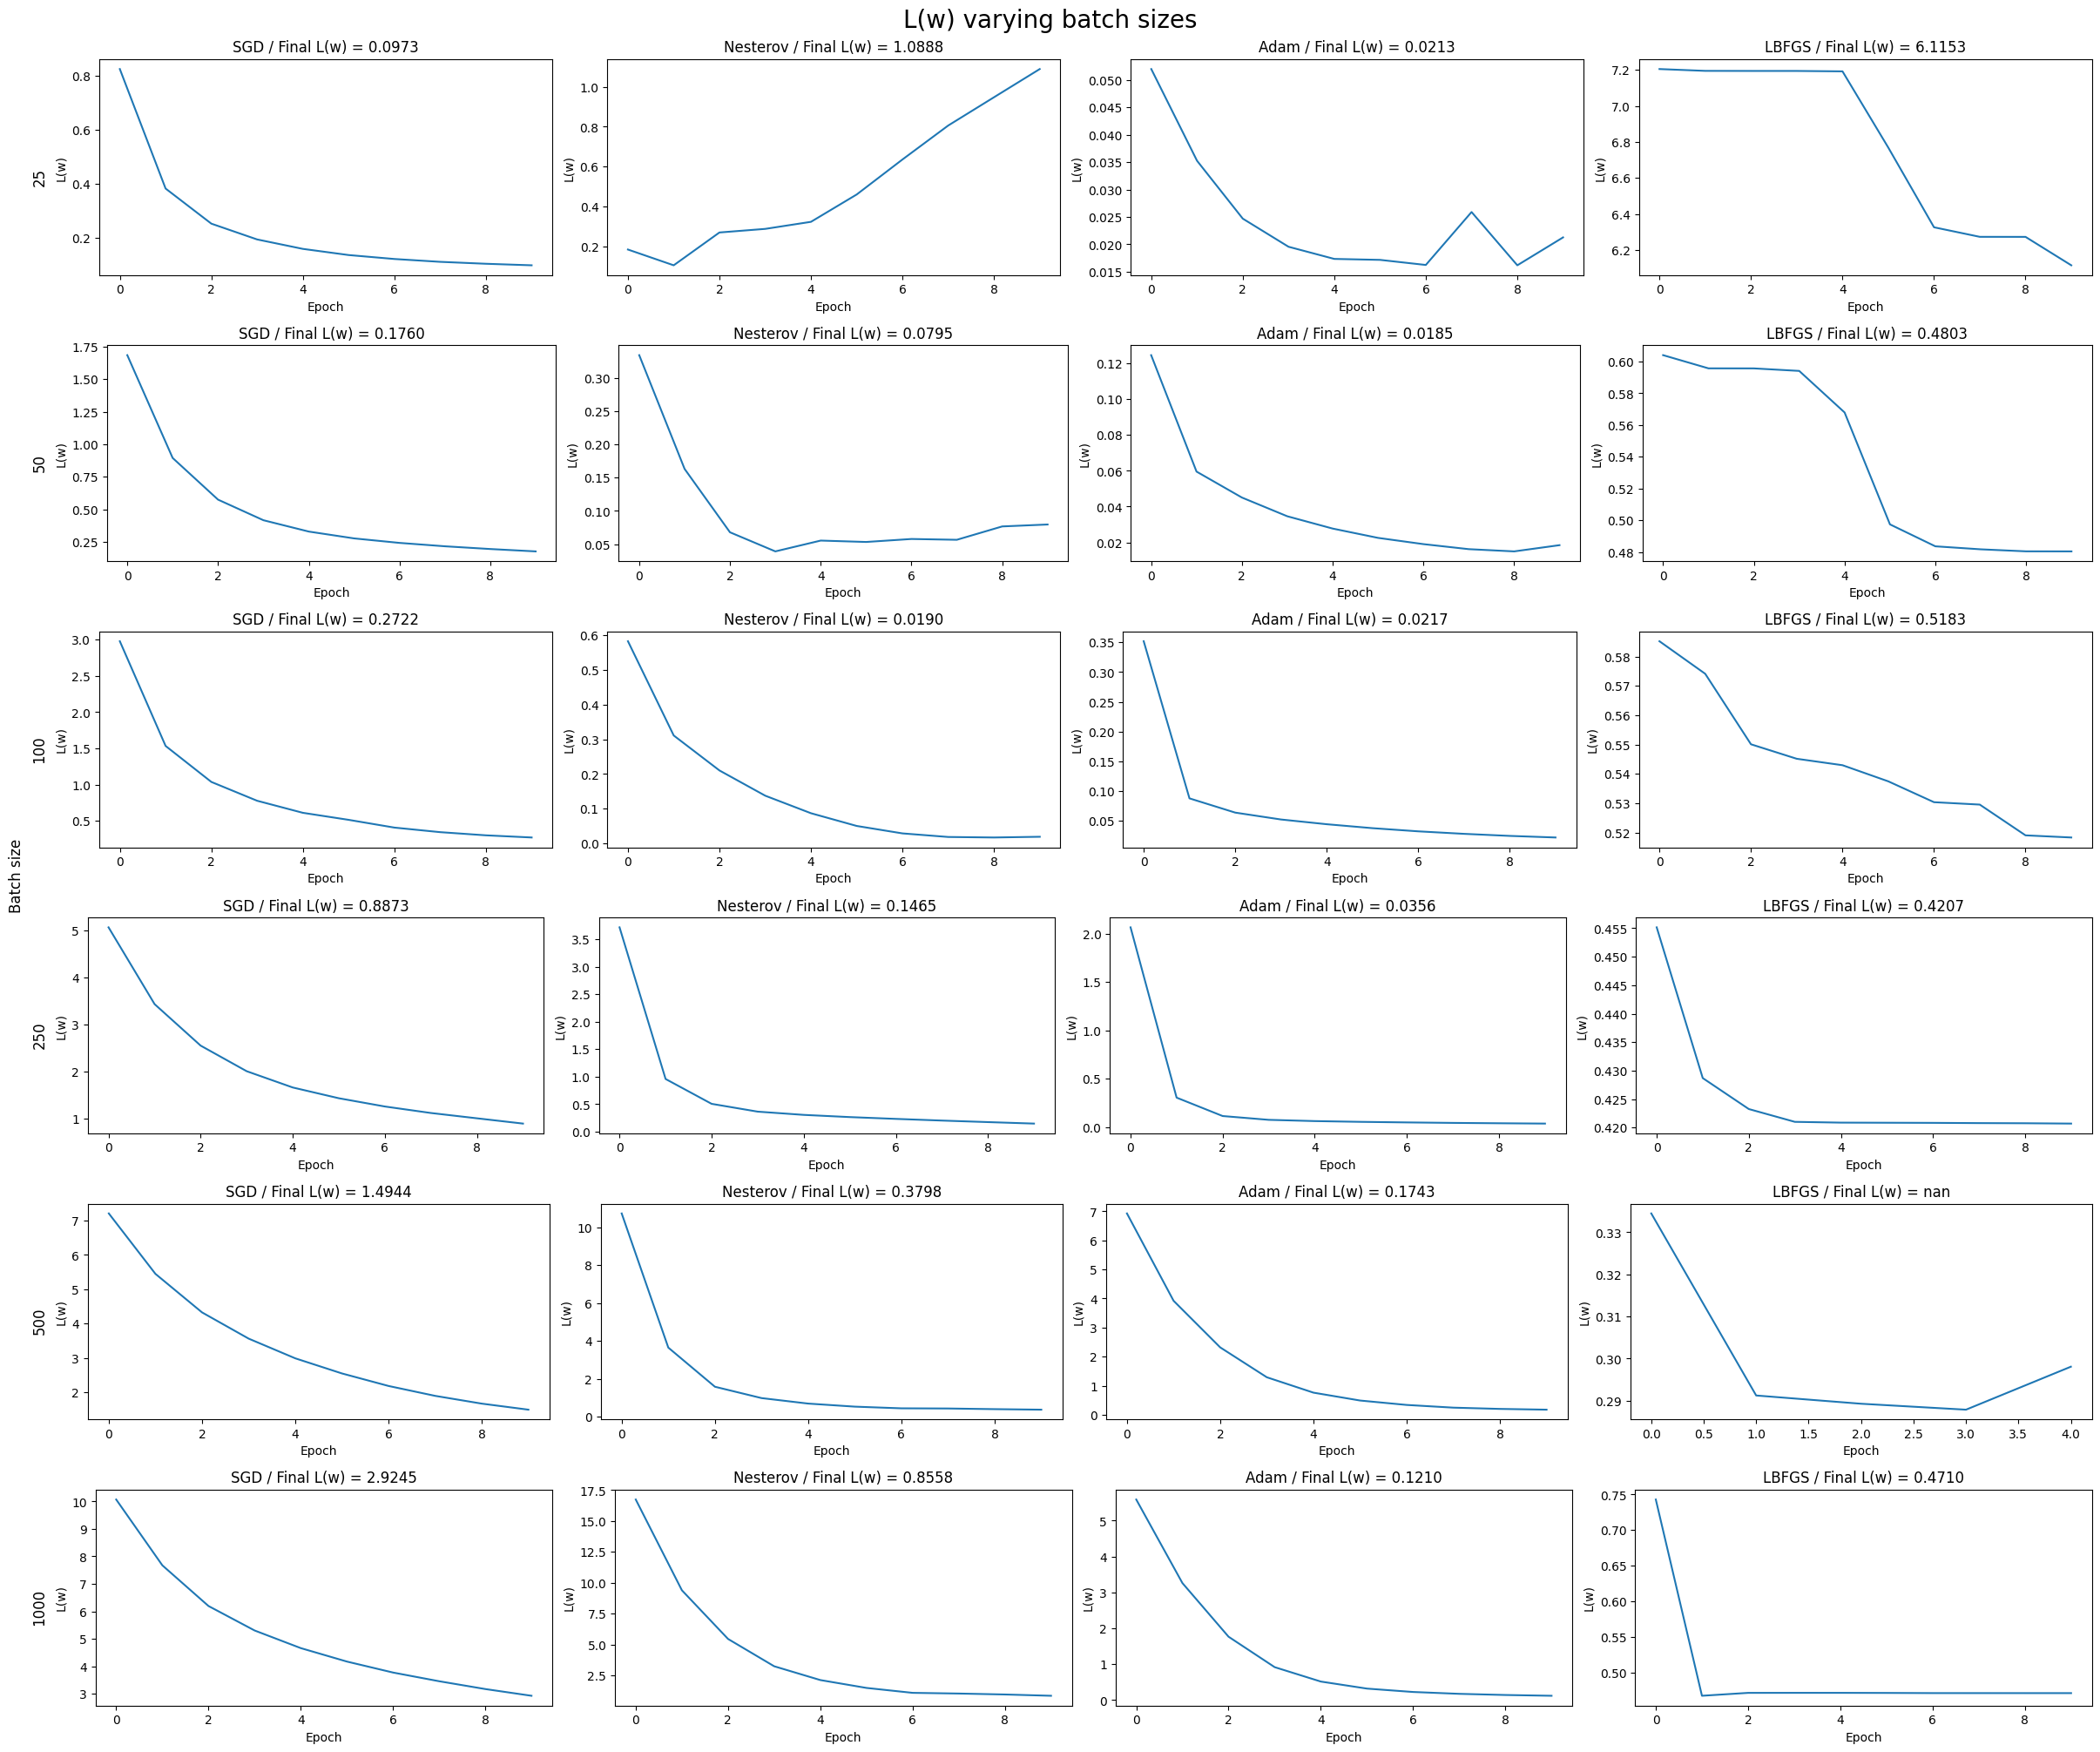

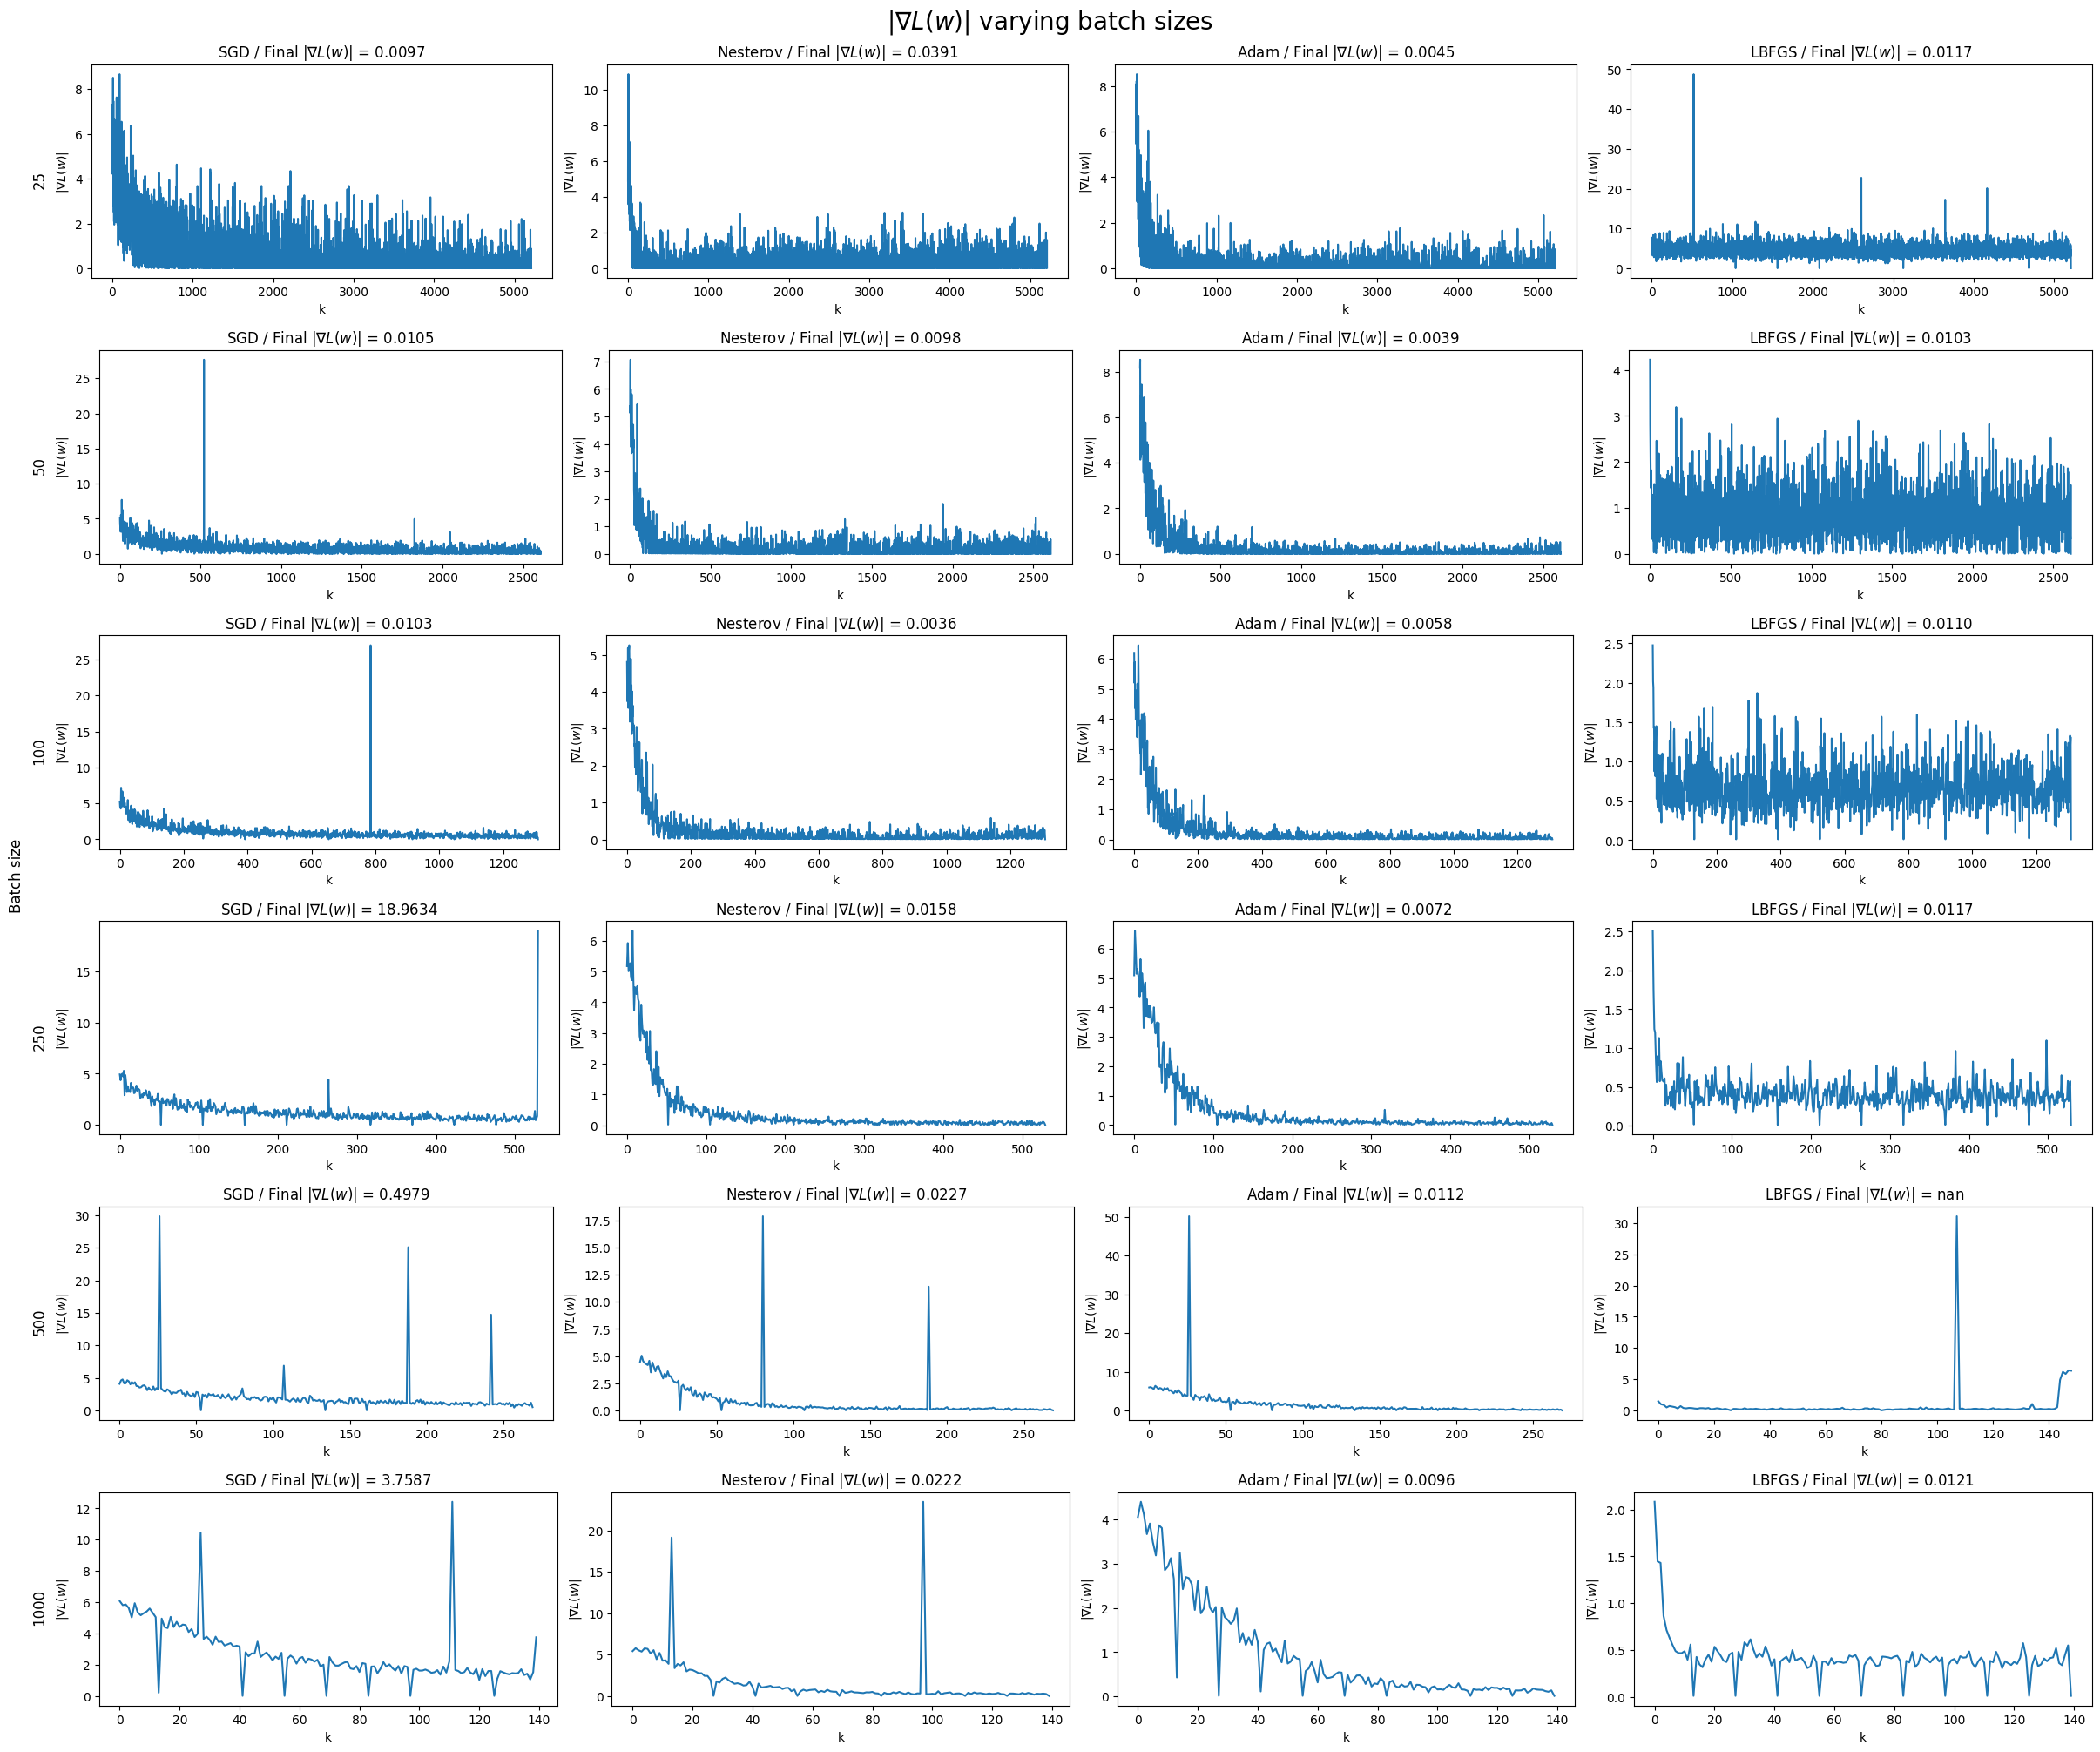

In [12]:
batch_sizes = [25, 50, 100, 250, 500, 1000]
compare_batch_size(batch_sizes, "p1_results")

SGD: 100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


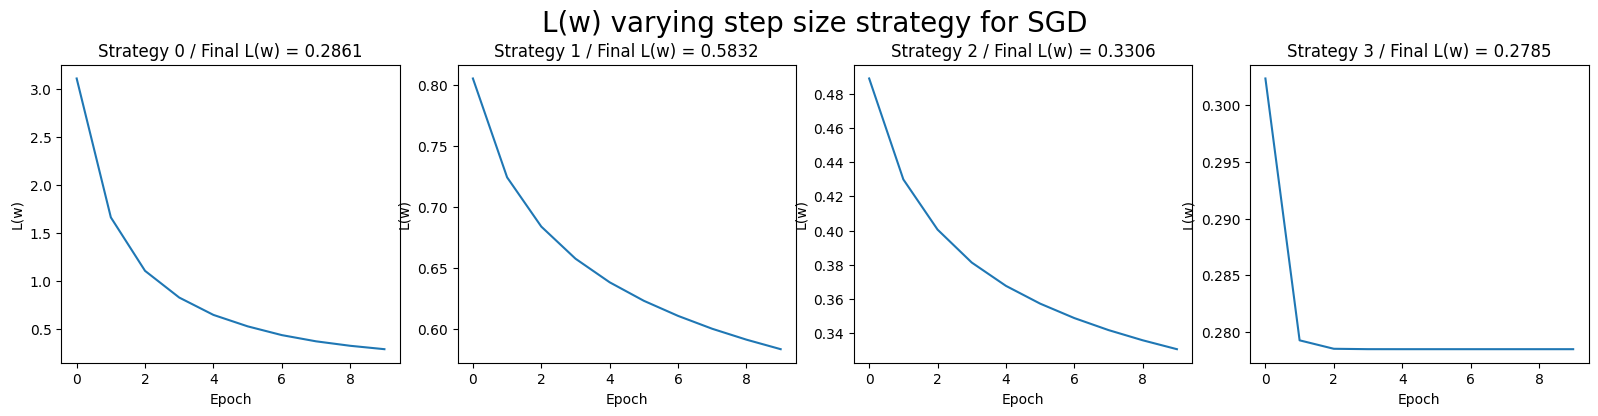

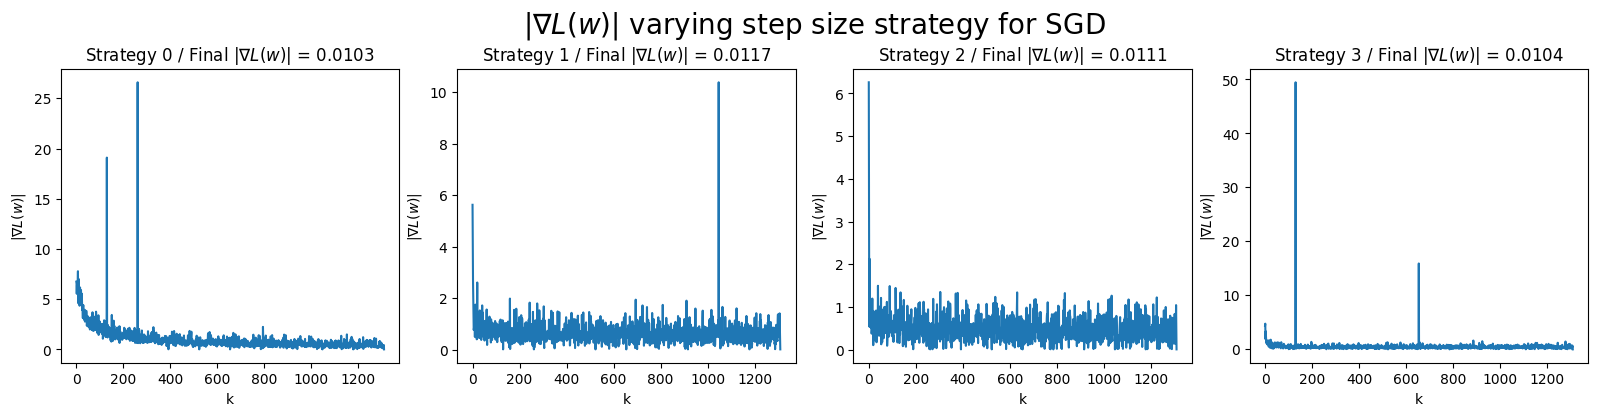

In [13]:
inverse1 = lambda k: 1 / (k + 1)
inverse2 = lambda k: 1 / (k / 2 + 1)
dec_step = lambda k: 0.2 / (2 ** (k // 30))

strategies = [0.01, inverse1, inverse2, dec_step]
sgd_stepsize_strategies(strategies, "p1_results")

L-BFGS: 100%|██████████| 10/10 [02:02<00:00, 12.23s/it]


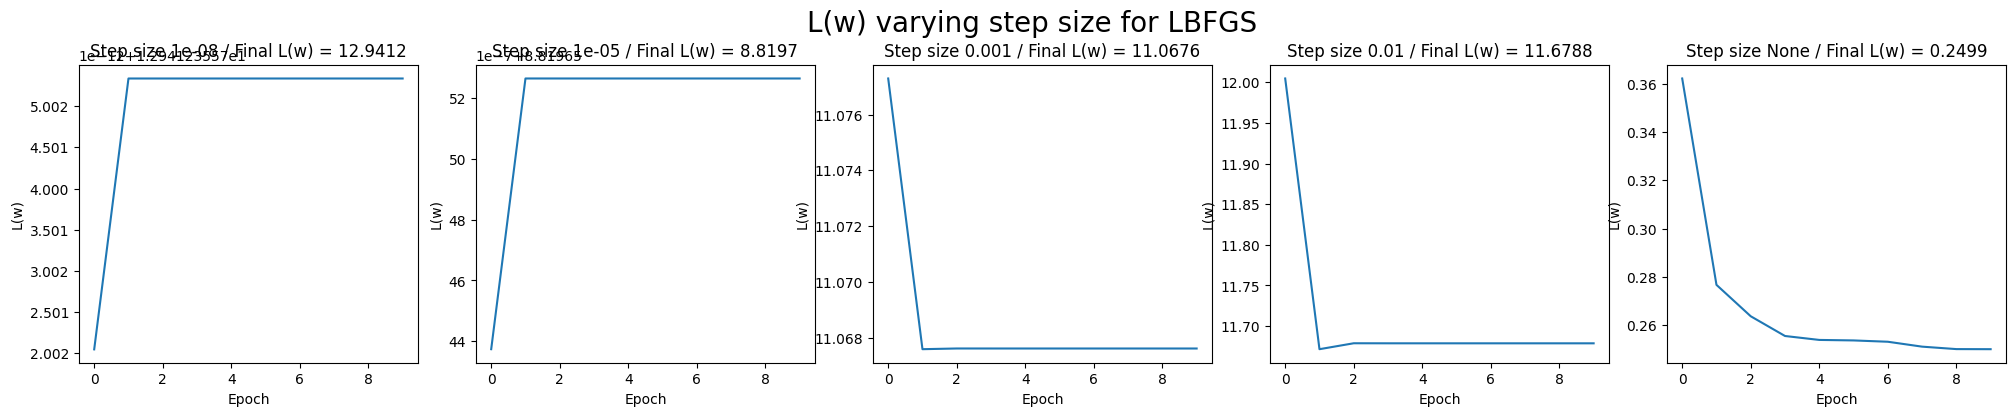

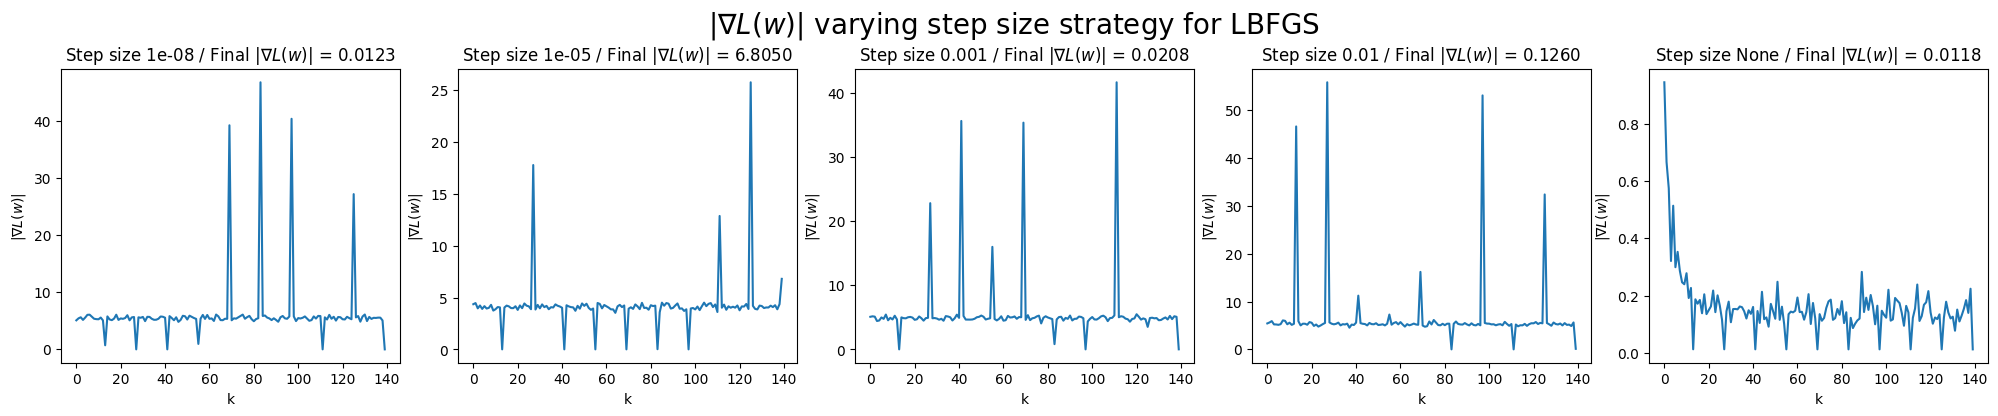

In [14]:
stepsizes = [1e-8, 1e-5, 1e-3, 0.01, None]
lbfgs_stepsize(stepsizes, "p1_results")

L-BFGS: 100%|██████████| 10/10 [01:49<00:00, 10.92s/it]


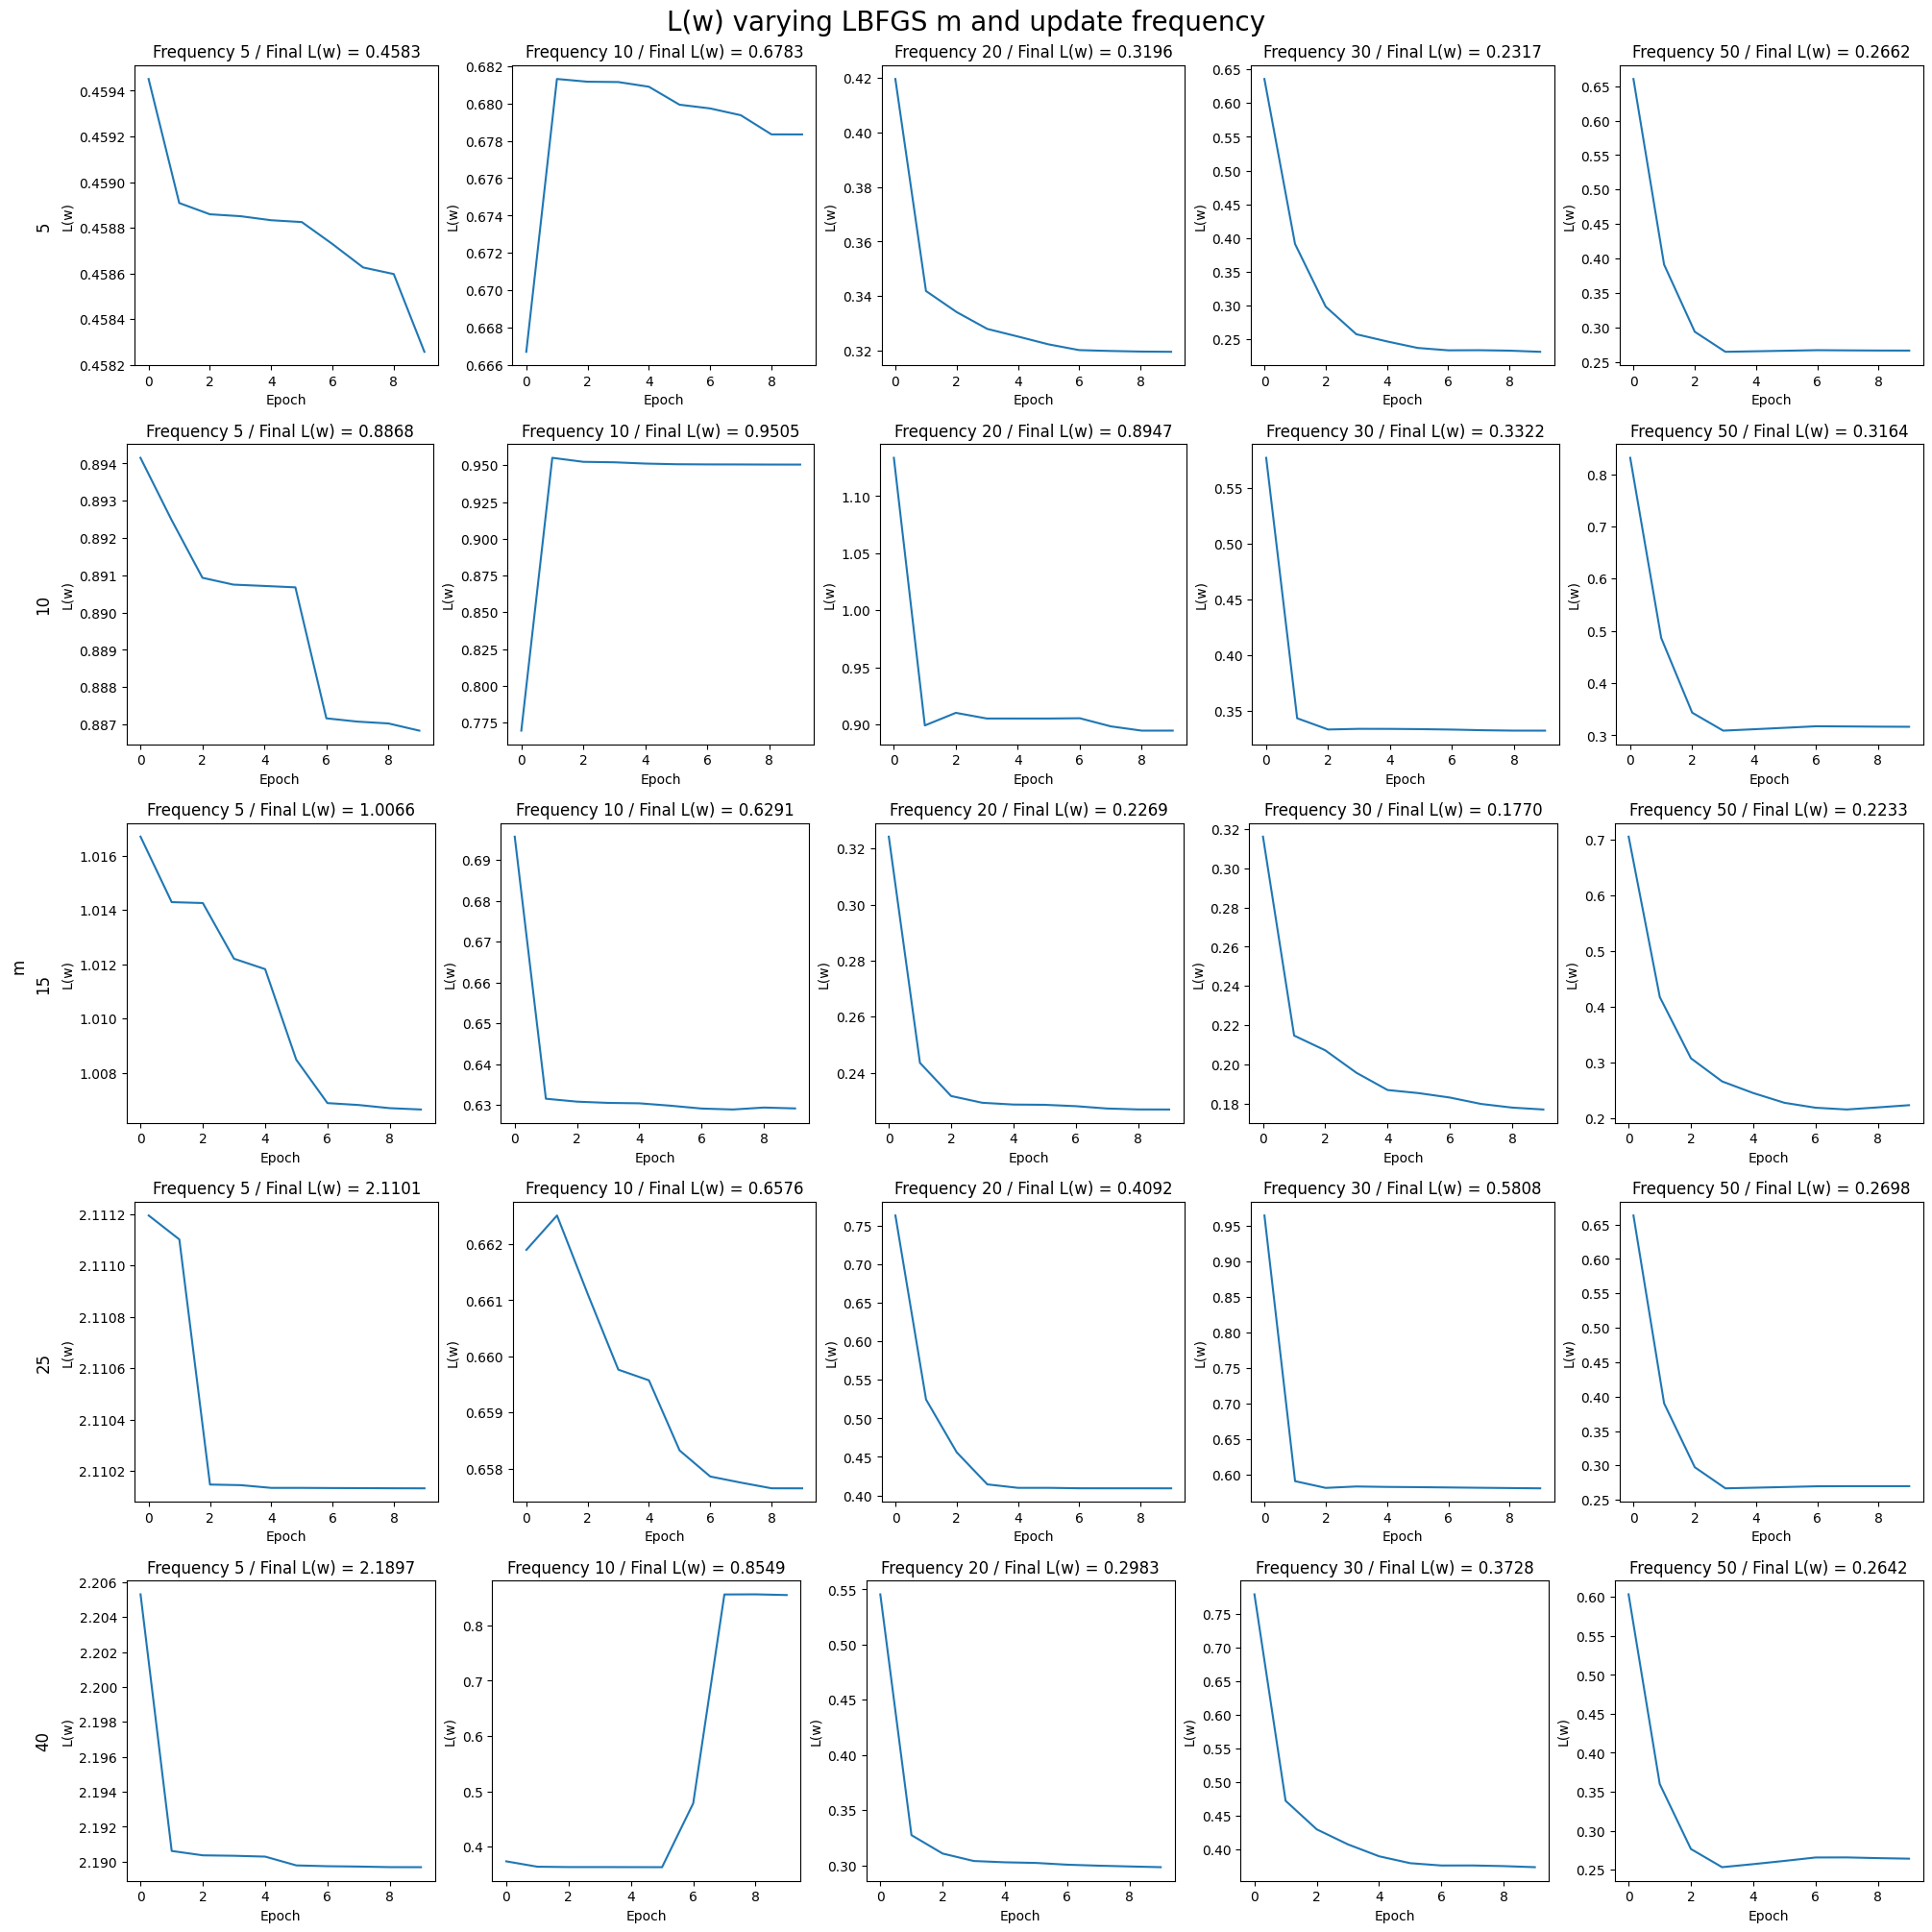

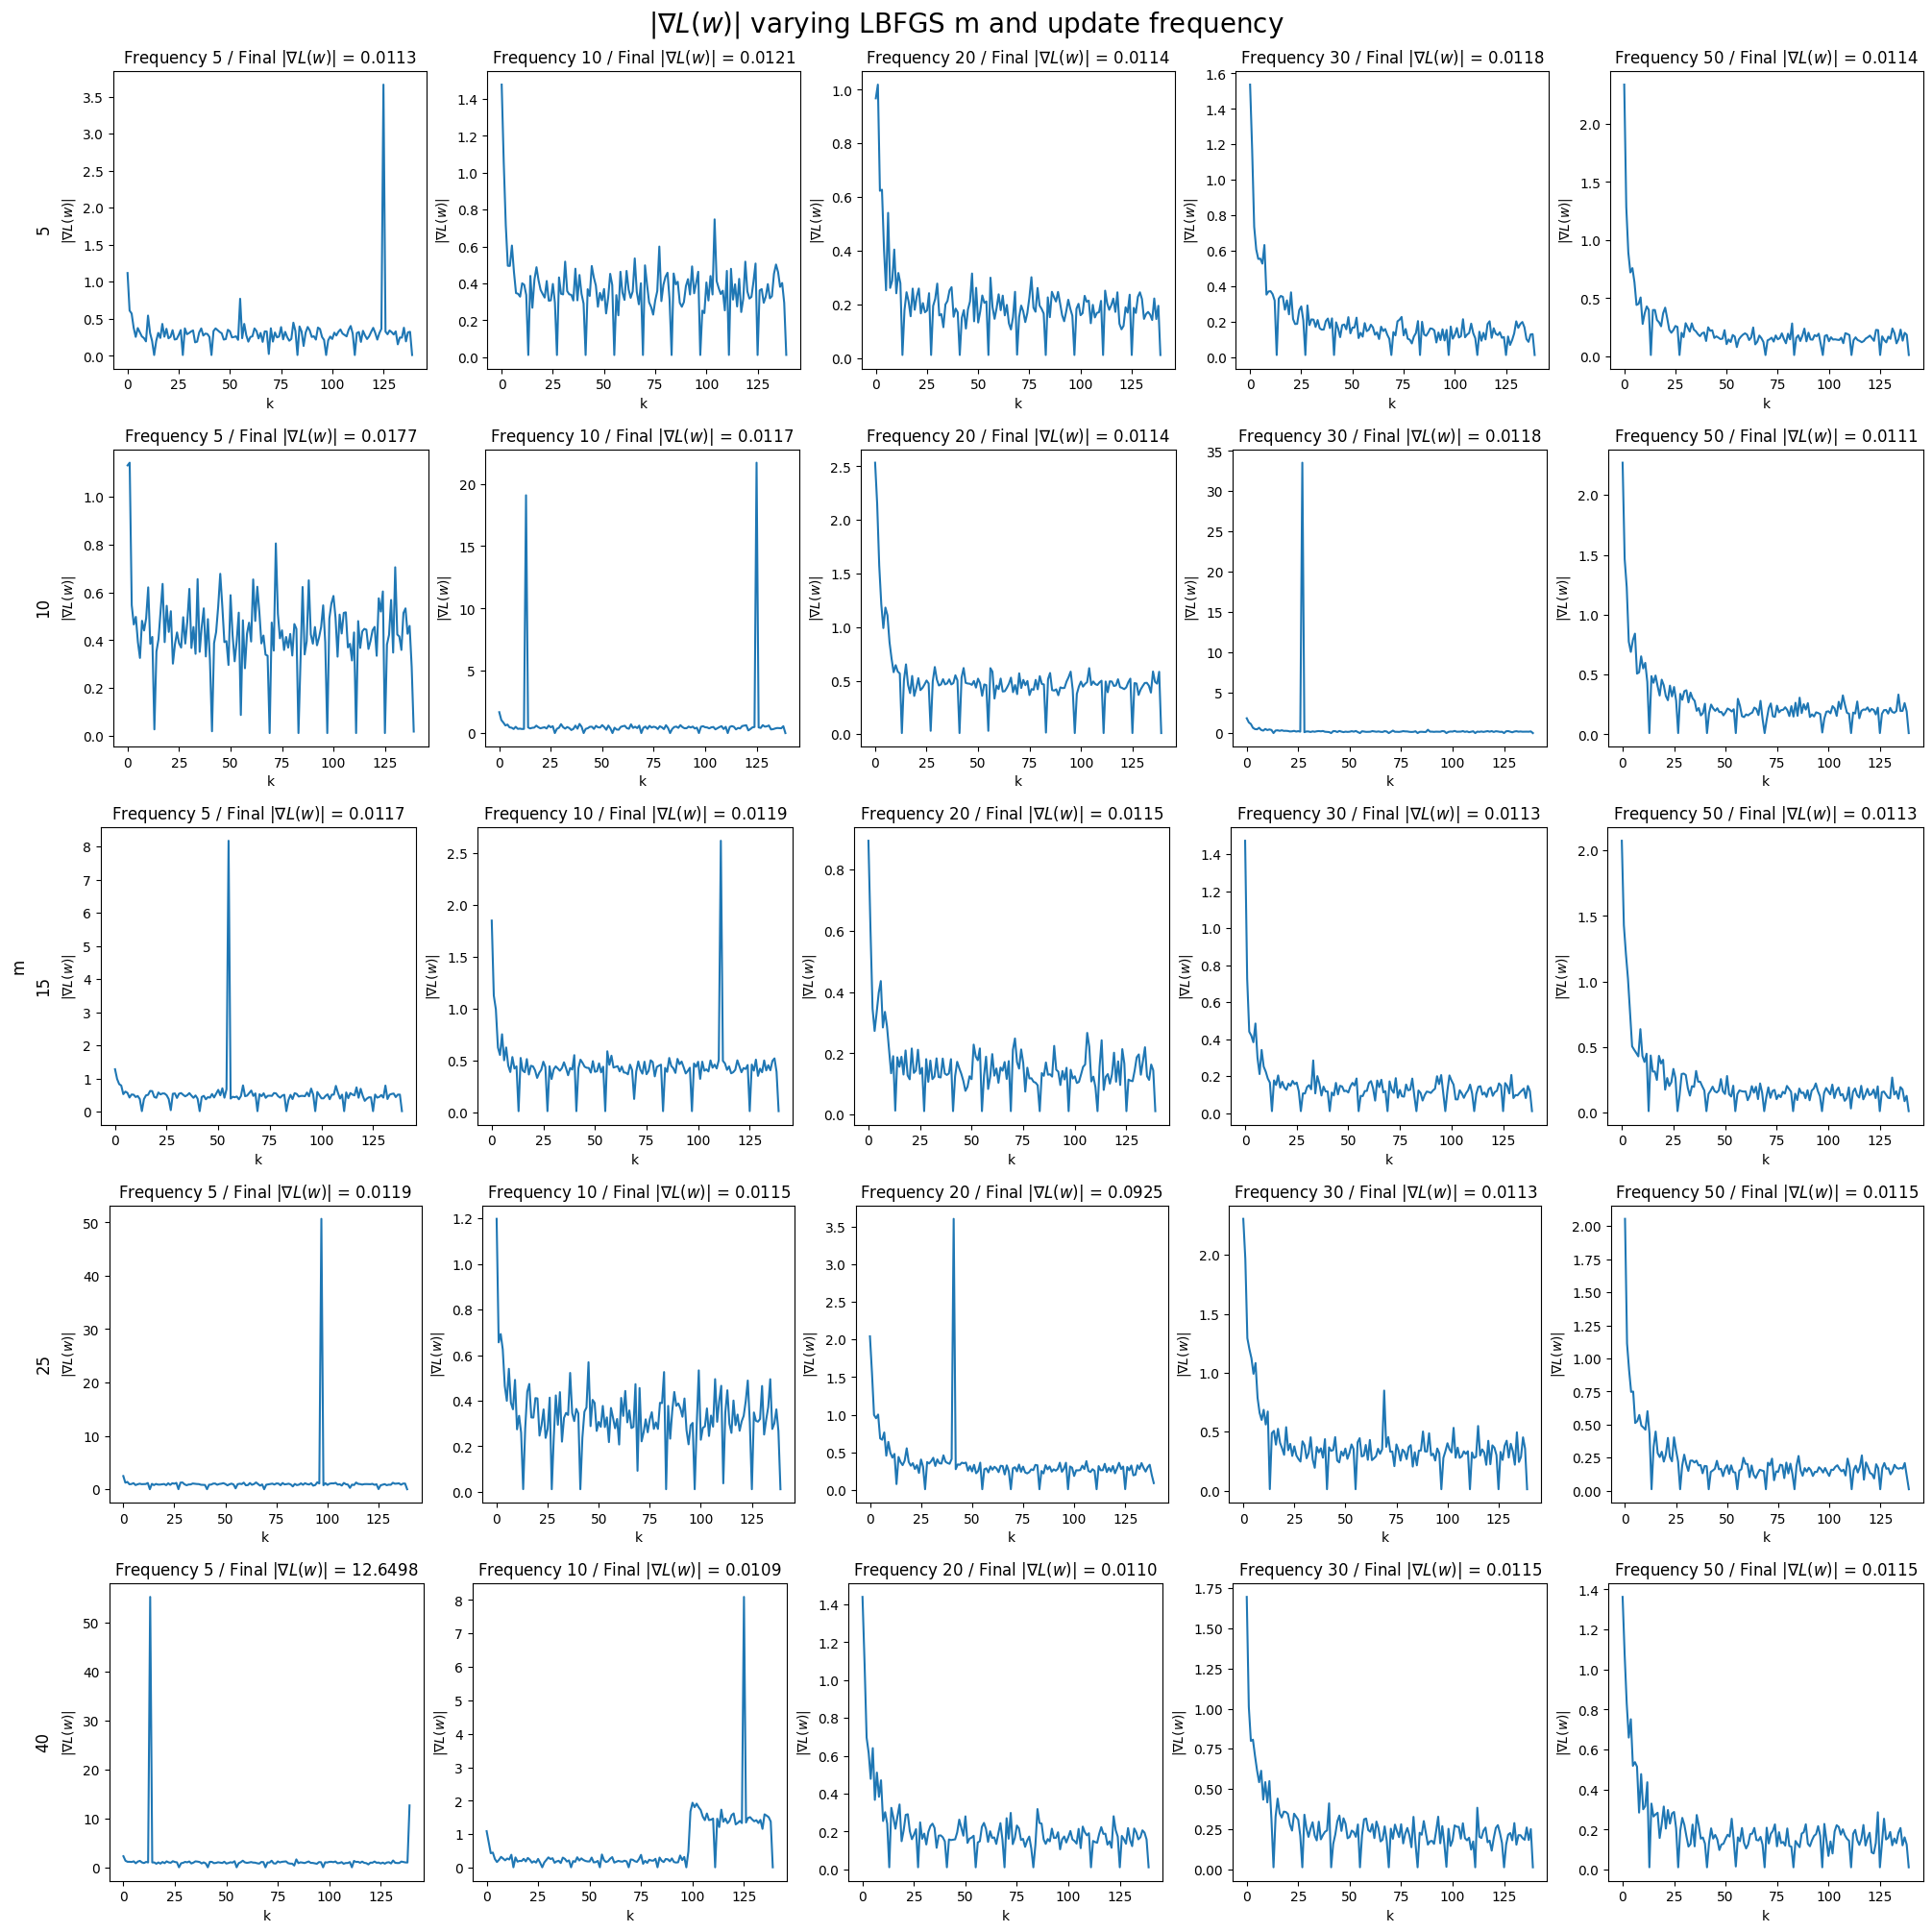

In [15]:
ms = [5, 10, 15, 25, 40]
frequencies = [5, 10, 20, 30, 50]
lbfgs_pairs_update(ms, frequencies, "p1_results")

Adam: 100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


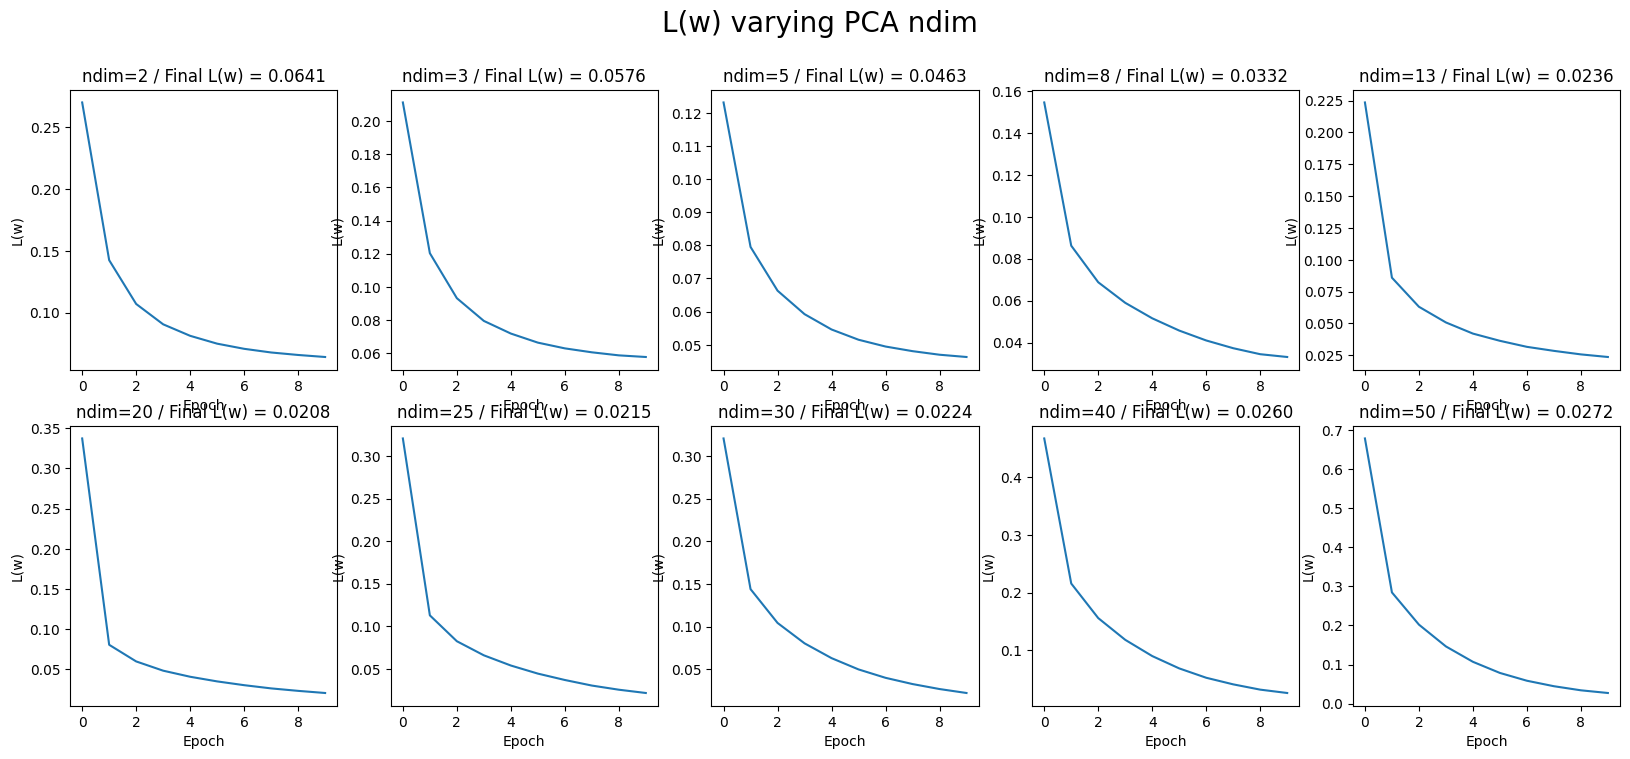

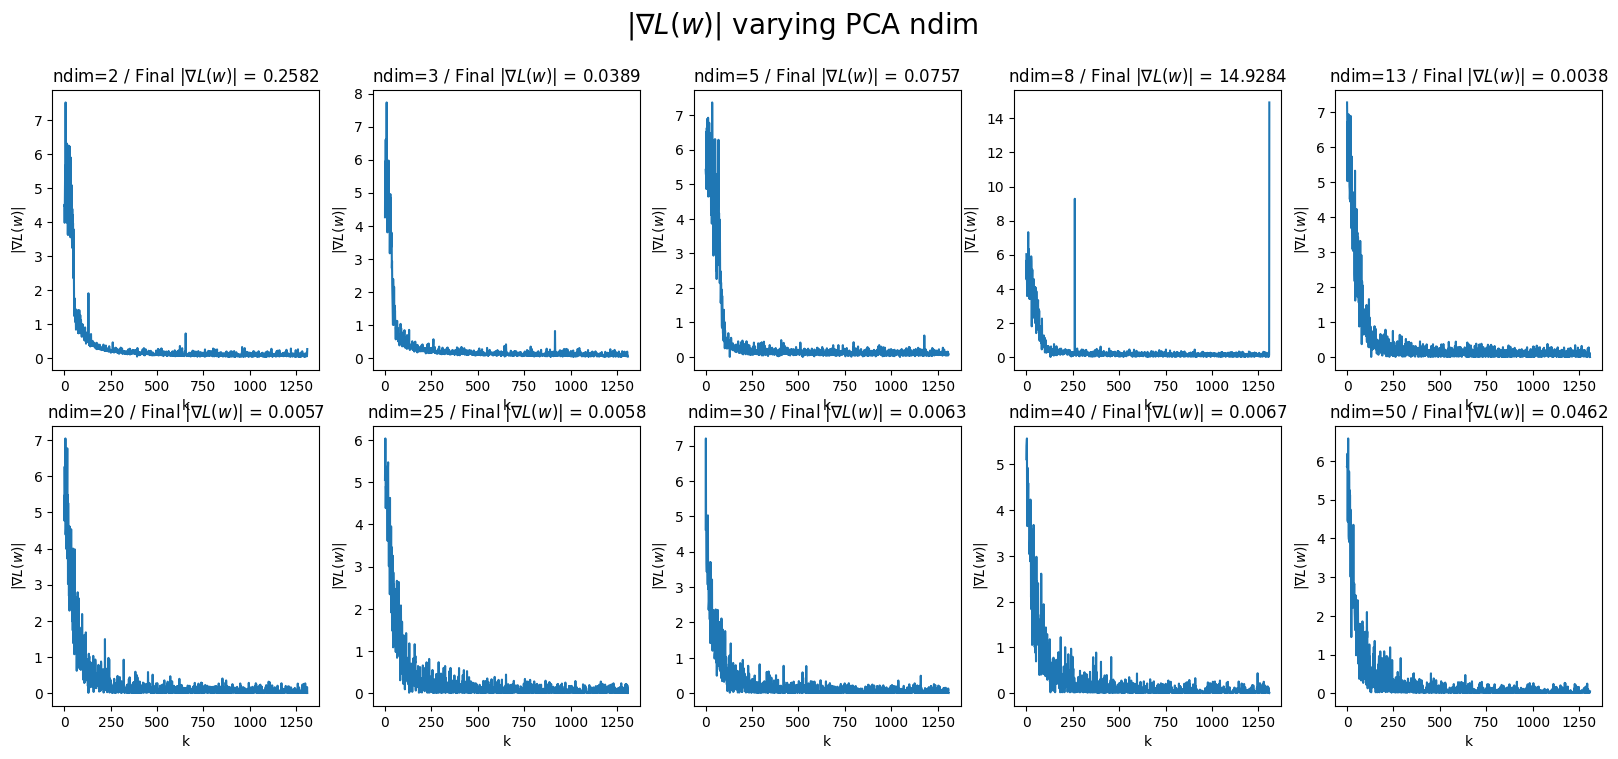

In [16]:
ds = [2, 3, 5, 8, 13, 20, 25, 30, 40, 50]
vary_pca(ds, "p1_results")

Adam: 100%|██████████| 10/10 [00:00<00:00, 60.47it/s]
/var/folders/jk/dnxlzcwx6jb9l9bdnwvqyrlc0000gn/T/ipykernel_79681/563373477.py:29: RuntimeWarning: invalid value encountered in sqrt
  disc = np.sqrt((b ** 2) - 4 * a * c)


train correct: 12775, train accuracy: 0.9821634504497578
test correct: 2117, test accuracy: 0.9787332408691632


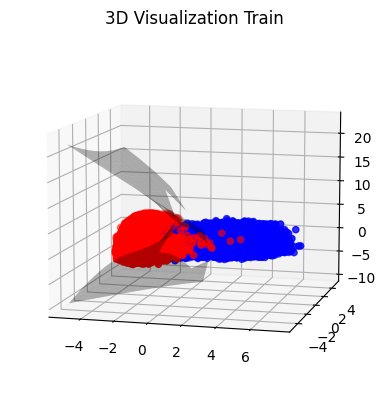

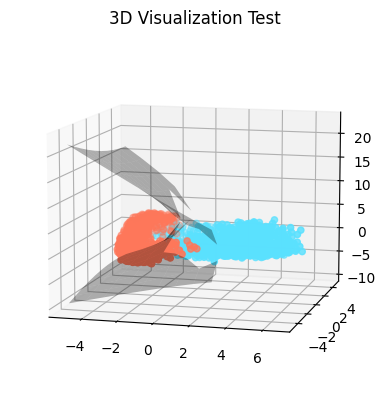

In [17]:
pca_3_plot("p1_results")

In [40]:
X_train_20g, X_test_20g = PCA_transform(20)
quad_traing = get_quadratic(X_train_20g, y_train)
quad_testg = get_quadratic(X_test_20g, y_test)

In [41]:
params = {
    "data": quad_traing,
    "batch_size": 20,
    "step_size": 0.01,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
}

sgd = SGD(**params)
w_sgd = sgd.minimize()
_ = eval_test_func(w_sgd, quad_traing, quad_testg, False)

SGD: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

train correct: 12912, train accuracy: 0.9926962404858922
test correct: 2144, test accuracy: 0.9912159038372631


In [42]:
params = {
    "data": quad_traing,
    "batch_size": 20,
    "step_size": 0.001,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
}

nesterov = Nesterov(**params)
w_nesterov = nesterov.minimize()
_ = eval_test_func(w_nesterov, quad_traing, quad_testg, False)

Nesterov: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]

train correct: 12949, train accuracy: 0.9955408626124395
test correct: 2150, test accuracy: 0.9939898289412853


In [162]:
params = {
    "data": quad_traing,
    "batch_size": 1000,
    "step_size": 0.01,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
}

adam = Adam(**params)
w_adam = adam.minimize()
_ = eval_test_func(w_adam, quad_traing, quad_testg, False)

Adam: 100%|██████████| 10/10 [00:02<00:00,  4.81it/s]


train correct: 12822, train accuracy: 0.9857768893672638
test correct: 2126, test accuracy: 0.9828941285251965


In [163]:
params = {
    "data": quad_traing,
    "batch_size": 1000,
    "step_size": None,
    "epochs": 10,
    "loss": loss_function,
    "grad": loss_gradient,
    "m": 10,
    "update_freq": 20,
}

lbfgs = LBFGS(**params)
w_lbfgs = lbfgs.minimize()
_ = eval_test_func(w_lbfgs, quad_traing, quad_testg, False)

L-BFGS: 100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


train correct: 7025, train accuracy: 0.5400937956484969
test correct: 1192, test accuracy: 0.5510864539990754
